# Modelo de previsão de valor de imóveis no Brasil
- O modelo tem como objetivo prever não só o valor do imóvel mas o IPTU e o valor de condóminio do imóvel perante um formulario a ser enviado pelo usuário.

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import logging

from dotenv import load_dotenv


### Configurações básicas de logger e carregamento de variáveis de ambiente

In [72]:
# Configurando o logging
logging.basicConfig(
    level=logging.INFO, # Nível mínimo para exibir
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)

# Crie uma instância do logger para este módulo
logger = logging.getLogger(__name__)

load_dotenv()

sns.set_theme(style="whitegrid")

### Requisição dos dados por meio de uma API

In [73]:
API_URL = "http://127.0.0.1:8000/consult-all-datas"
SECRET_KEY = os.getenv("API_KEY")

headers = {
    "X-API-KEY":SECRET_KEY
}

try:
    response = requests.get(url=API_URL, headers=headers)
    
    response.raise_for_status()
    
    data = response.json()
    
    if data:
        df = pd.DataFrame(data)
        logger.info("Dados carregados no DataFrame com sucesso!")
        logger.info(f"Total de registros: {len(df)}")
        logger.info(f" ---> Primeiras 5 linhas: \n \n{df.head()}")
        logger.info("\nInformações do DataFrame:")
        df.info()
    else:
        logger.info("A API retornou uma lista vazia.")
except requests.exceptions.HTTPError as http_error:
    logger.error(f"Erro HTTP ocorreu: {http_error}")
    logger.error(f"Conteúdo da resposta: {response.text}")
except requests.exceptions.RequestException as req_error:
    logger.error(f"Erro da requisição ocorreu: {req_error}")

2025-09-27 18:34:17 - __main__ - INFO - Dados carregados no DataFrame com sucesso!
2025-09-27 18:34:17 - __main__ - INFO - Total de registros: 33940
2025-09-27 18:34:17 - __main__ - INFO -  ---> Primeiras 5 linhas: 
 
           id property_type      price  price_condominium   iptu  area_m2  \
0  2838574939          casa  2450000.0                NaN    NaN      198   
1  2838818725          casa   480000.0                NaN  144.0      110   
2  2833329978     quitinete   675000.0              750.0  120.0       35   
3  2827498230   apartamento   185000.0              250.0    NaN       50   
4  2795928117   apartamento   680000.0                NaN    NaN       94   

   rooms  bathrooms  vacancies                   city     neighborhood  
0      3          3          3                Pelotas           Centro  
1      3          3          4  Campos dos Goytacazes  Parque Imperial  
2      1          1          1         Rio de Janeiro       Copacabana  
3      2          1        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33940 entries, 0 to 33939
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 33940 non-null  object 
 1   property_type      33940 non-null  object 
 2   price              33940 non-null  float64
 3   price_condominium  16273 non-null  float64
 4   iptu               22784 non-null  float64
 5   area_m2            33940 non-null  int64  
 6   rooms              33940 non-null  int64  
 7   bathrooms          33940 non-null  int64  
 8   vacancies          33940 non-null  int64  
 9   city               33940 non-null  object 
 10  neighborhood       33940 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 2.8+ MB


## Analisando os dados

- Verificando quantos tipos de imoveis possui o dataset

In [74]:
freq_tipo_propriedades = df["property_type"].value_counts()
print(freq_tipo_propriedades)

property_type
casa           8479
sobrados       8261
apartamento    7972
quitinete      7386
terreno         925
fazenda         757
studio          106
flat             28
cobertura        25
loft              1
Name: count, dtype: int64


In [75]:
freq_cidade = df["city"].value_counts()
print(freq_cidade)

city
São Paulo                 13791
Rio de Janeiro             1683
Santo André                1244
Porto Alegre                952
São Bernardo do Campo       952
                          ...  
São Francisco de Paula        1
Ilhabela                      1
Palmares do Sul               1
Cruzeiro                      1
Água Boa                      1
Name: count, Length: 536, dtype: int64


In [76]:
freq_bairro = df["neighborhood"].value_counts()
print(freq_bairro)

neighborhood
Centro                              1593
Copacabana                           461
Bela Vista                           384
Vila Mariana                         308
Pinheiros                            296
                                    ... 
Parque das Aroeiras                    1
Parque Residencial João da Silva       1
Silva                                  1
AGENOR DE CAMPOS                       1
Portal da Primavera                    1
Name: count, Length: 5247, dtype: int64


In [77]:
df.describe()

,price,price_condominium,iptu,area_m2,rooms,bathrooms,vacancies
count,3.394000e+04,1.627300e+04,2.278400e+04,3.394000e+04,33940.000000,33940.000000,33940.000000
mean,9.472309e+05,2.298727e+03,1.019320e+03,4.585307e+03,2.810342,2.262581,2.898232
std,2.104962e+06,4.495534e+04,1.795114e+04,1.241356e+05,7.826231,1.554000,19.311139
min,6.000000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3.650000e+05,3.500000e+02,8.500000e+01,4.900000e+01,1.000000,1.000000,1.000000
50%,6.000000e+05,5.000000e+02,2.060000e+02,1.150000e+02,2.000000,2.000000,2.000000
75%,9.500000e+05,7.600000e+02,6.000000e+02,2.090000e+02,3.000000,3.000000,3.000000
max,1.200000e+08,2.690000e+06,2.000000e+06,1.173770e+07,911.000000,22.000000,1015.000000


- Analisando os 10 maiores valores de condôminio e os 60 menores. (outliers)

In [78]:
print(df.nlargest(10, "price_condominium"))
print(df.nsmallest(60, "price_condominium"))

               id property_type      price  price_condominium   iptu  area_m2  \
17358  2823937760          casa  2690000.0          2690000.0    NaN      318   
20483  2831826620          casa  2690000.0          2690000.0    NaN      318   
15181  2837726835   apartamento  2800000.0          2219760.0  664.0      128   
549    2838841139          casa  2190000.0          1500000.0  523.0      243   
30070  2761271750      sobrados  1500000.0          1500000.0    NaN      196   
15572  2838950914   apartamento  1890000.0          1400000.0  340.0       72   
28662  2744704510          casa   950000.0           950000.0    NaN      128   
28161  2798615426      sobrados   829000.0           829000.0    NaN      126   
20781  2800823525          casa   729000.0           729000.0    NaN      109   
10235  2788409934          casa   700000.0           700000.0    NaN       85   

       rooms  bathrooms  vacancies                  city  \
17358      5          6          4              

- Analisando os 10 maiores valores de IPTU e os 500 menores. (outliers)

In [79]:
print(df.nlargest(10, "iptu"))
print(df.nsmallest(500, "iptu"))

               id property_type      price  price_condominium       iptu  \
17741  2834737429      sobrados   800000.0                NaN  2000000.0   
30701  2798617716          casa  1500000.0              330.0  1100000.0   
30015  2765690714      sobrados  1800000.0                NaN   800000.0   
13467  2557468578      sobrados   950000.0                NaN   670000.0   
5229   2828538588       terreno  1175000.0                NaN   480000.0   
9157   2835137020          casa  1100000.0                NaN   468442.0   
4813   2764628841       terreno   295000.0                NaN   451000.0   
3993   2689800741      sobrados   599970.0                NaN   245940.0   
7101   2818200681   apartamento   307000.0           400000.0   230000.0   
17116  2834964827   apartamento   307000.0           400000.0   230000.0   

       area_m2  rooms  bathrooms  vacancies             city  \
17741      128      3          4          4        Guarulhos   
30701      260      3          1   

In [80]:
print(df.nlargest(10, "vacancies"))
print(df.nsmallest(60, "vacancies"))

               id property_type       price  price_condominium     iptu  \
13530  2820295696          casa  25000000.0             2000.0  14400.0   
3352   2816221014       fazenda   1300000.0                NaN    185.0   
10420  2725786645     quitinete   1389000.0              890.0      NaN   
5358   2828255419       fazenda   3400000.0              400.0   3200.0   
27908  2839045215      sobrados    670000.0                NaN      NaN   
26147  2839123439          casa   2680000.0                NaN      NaN   
9018   2682370119      sobrados   3350000.0                NaN   2680.0   
9738   2824987059      sobrados    949000.0                NaN      NaN   
13077  2572975484      sobrados    949000.0                NaN      NaN   
21276  2806605618          casa   2200000.0                NaN    580.0   

       area_m2  rooms  bathrooms  vacancies                   city  \
13530     2329      6         11       1015                Barueri   
3352       200      3          4  

In [81]:
print(df.nlargest(10, "bathrooms"))
print(df.nsmallest(60, "bathrooms"))

               id property_type       price  price_condominium    iptu  \
13474  2703115489      sobrados    790000.0                NaN    88.0   
5386   2811569032       fazenda   5500000.0                NaN    10.0   
23819  2837982923   apartamento   5999900.0                1.0   265.0   
13458  2783378732      sobrados   1480000.0                NaN     NaN   
27003  2839467423          casa   3000000.0                NaN     NaN   
33324  2782248893      sobrados  44900000.0                NaN  7800.0   
26715  2823611927      sobrados   2224940.0                NaN     NaN   
12549  2668436111      sobrados   3690000.0                NaN  1058.0   
21524  2810912748          casa   1600000.0                NaN  1069.0   
5368   2823698717       fazenda   1650000.0                NaN   110.0   

       area_m2  rooms  bathrooms  vacancies           city  \
13474   147158      3         22          3      São Paulo   
5386    144000     25         20         30      Mairiporã   

In [82]:
print(df.nlargest(10, "area_m2"))
print(df.nsmallest(60, "area_m2"))

               id property_type        price  price_condominium     iptu  \
2850   2791260049       fazenda  120000000.0                NaN    100.0   
2720   2688525934       fazenda   60000000.0                NaN      NaN   
30576  2696194385          casa    6900000.0             3000.0  18000.0   
3327   2811106567       fazenda   45000000.0                NaN    200.0   
4020   2831976716       fazenda   90000000.0                NaN      NaN   
4431   2642267800       terreno    1200000.0                NaN      NaN   
2783   2835215722       fazenda   65000000.0                NaN      NaN   
2950   2825659491       fazenda    7700000.0                NaN      NaN   
5323   2774697332       fazenda    6300000.0                NaN      NaN   
2113   2825662831       fazenda  107000000.0                NaN      NaN   

        area_m2  rooms  bathrooms  vacancies                     city  \
2850   11737700      1          1          0               São Manuel   
2720    9490000  

c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Chall

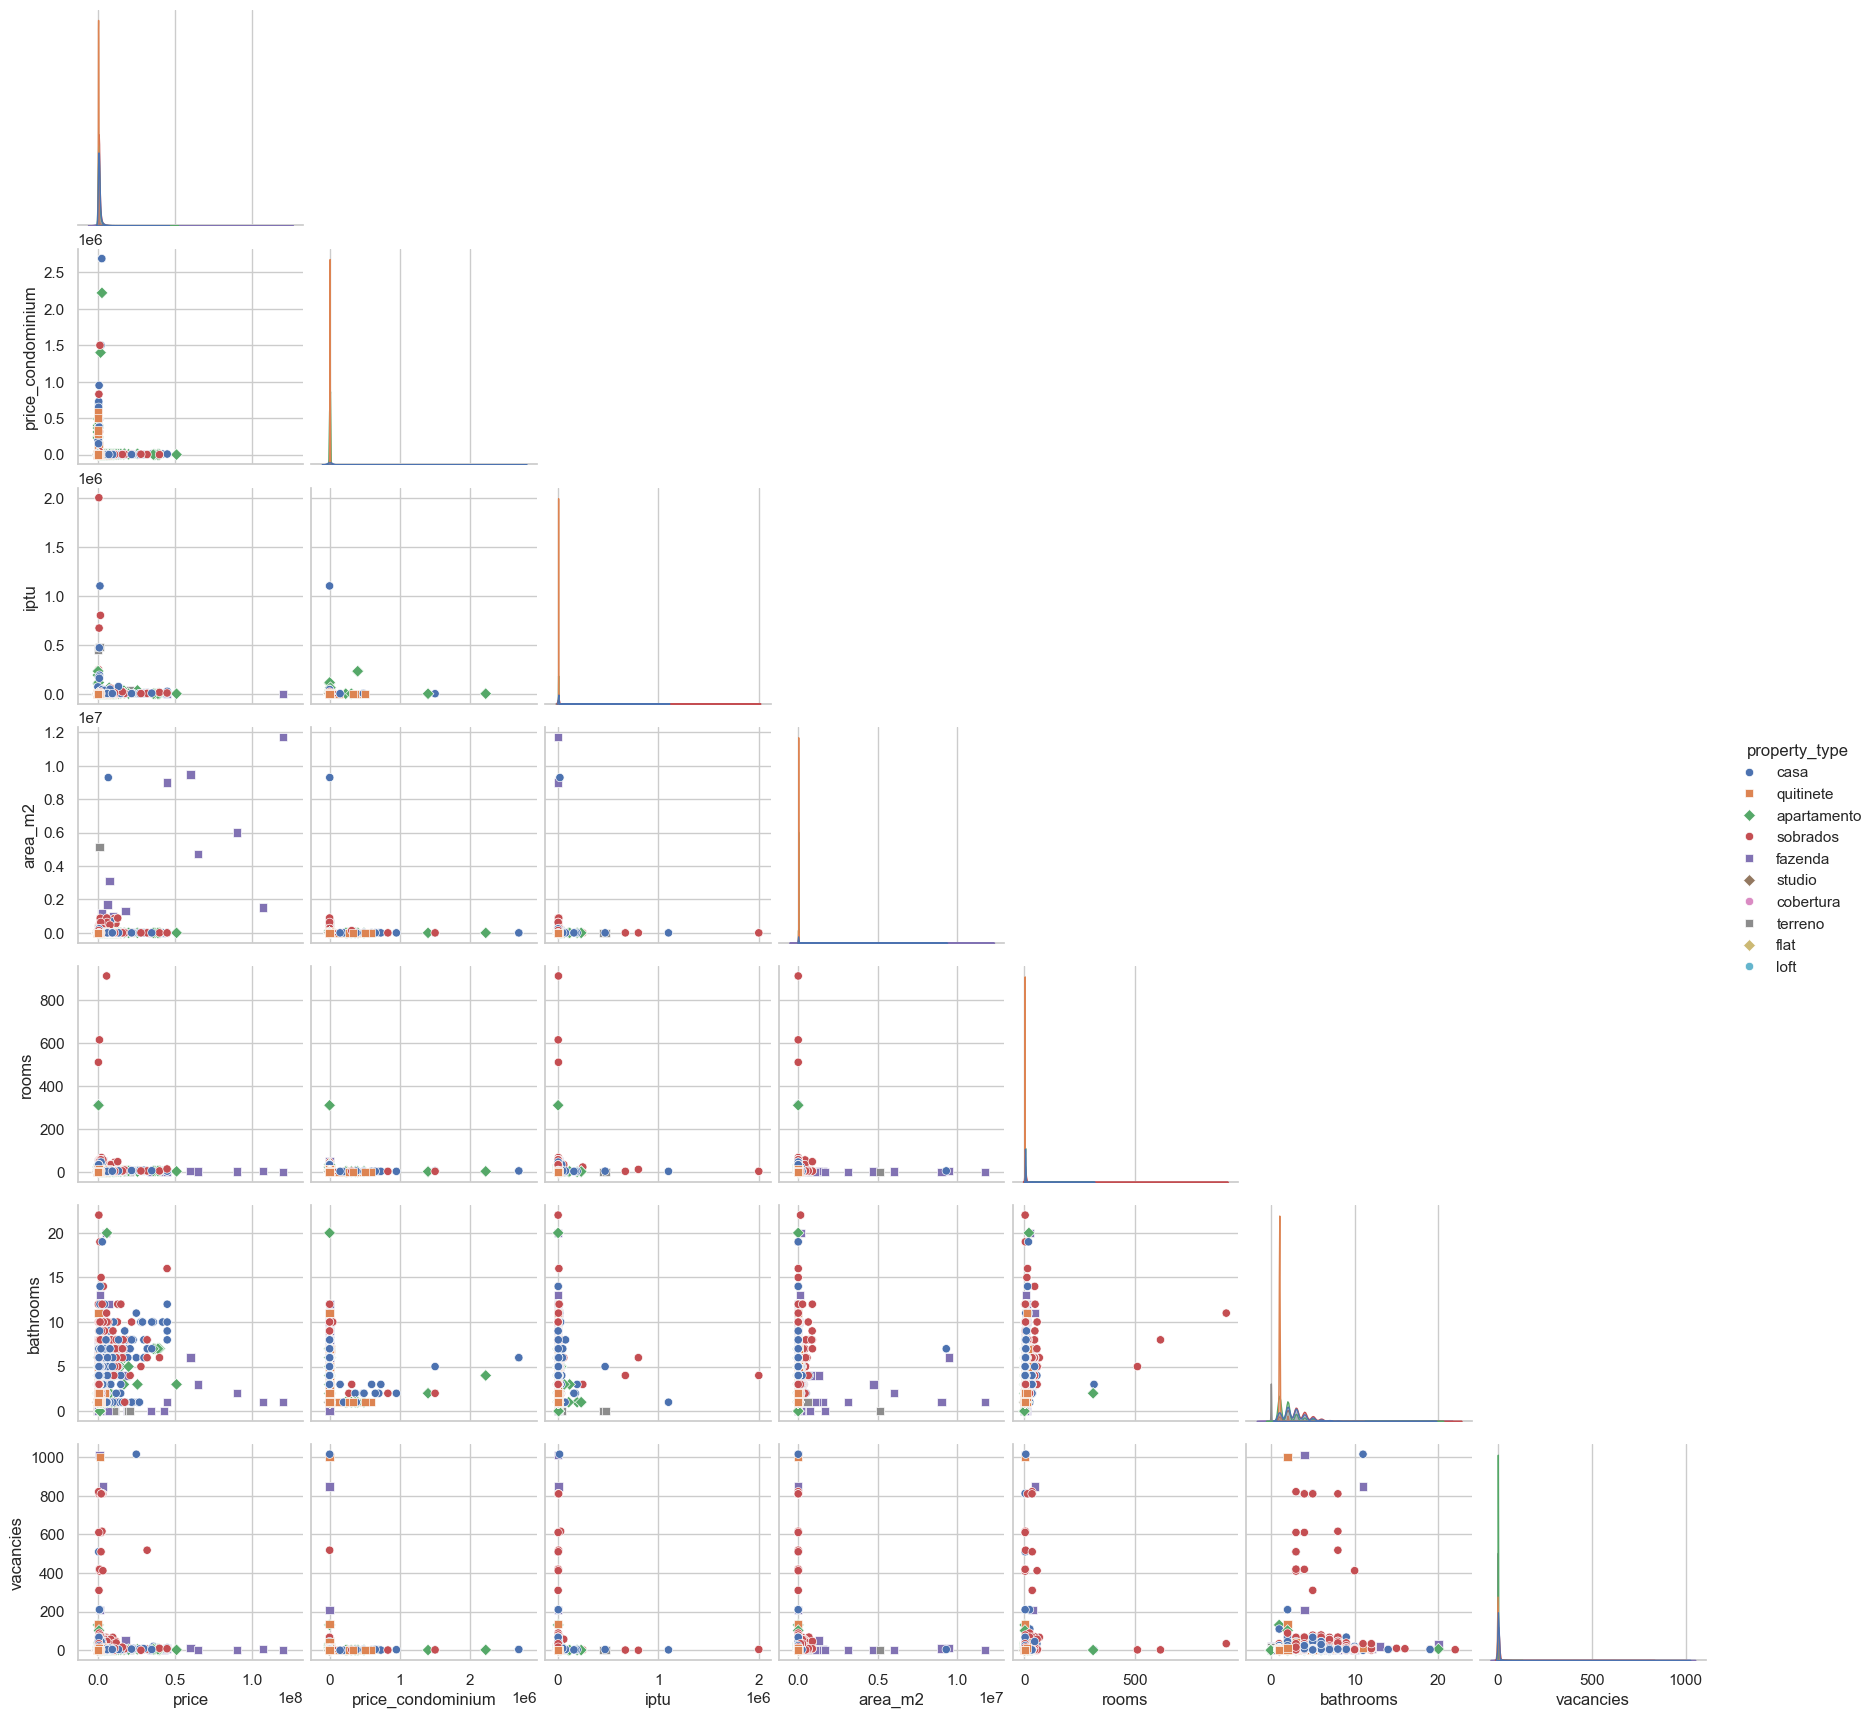

In [83]:
sns.pairplot(df, hue='property_type', markers=['o', 's', 'D'], corner=True) # Uma visualização com seaborn 2 a 2 para analisar como está a distribuição

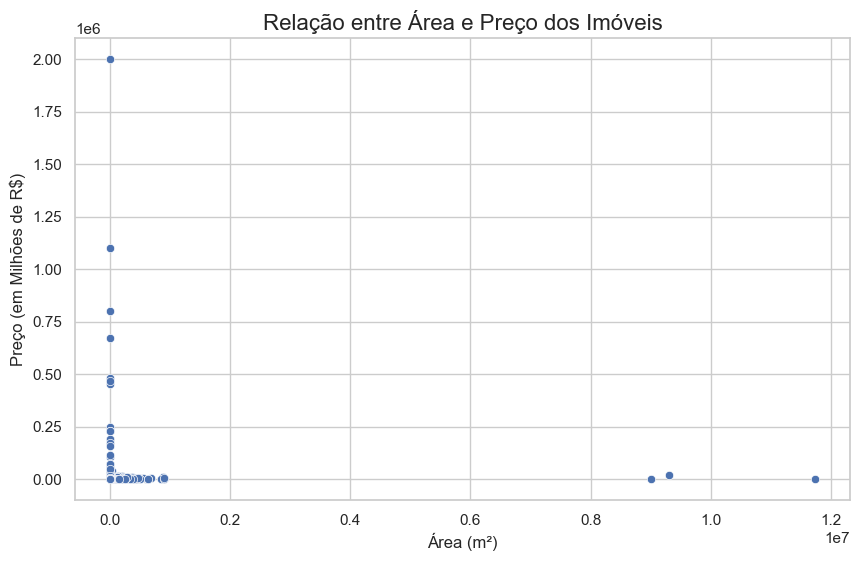

In [84]:
plt.figure(figsize=(10, 6))

graf_dispersao = sns.scatterplot(
    data=df,
    x="area_m2",
    y="iptu"
)

graf_dispersao.set_title('Relação entre Área e Preço dos Imóveis', fontsize=16)
graf_dispersao.set_xlabel('Área (m²)', fontsize=12)
graf_dispersao.set_ylabel('Preço (em Milhões de R$)', fontsize=12)

# Exibindo o gráfico
plt.show()